# Intro

In this notebook, we explore a collection of ancient Akkadian and ancient Egyptian texts using the vector space model approach described by [Karsdorp et al. in the chapter "Exploring Texts using the Vector Space Model"](https://www.humanitiesdataanalysis.org/vector-space-model/notebook.html). By representing the texts as numeric vectors capturing word frequencies, we can quantify the lexical similarities and differences between corpora in each of these two ancient languages. The vector space model allows us to reason about texts spatially and apply geometric concepts like distance metrics to assess how "close" texts are to each other based on shared vocabulary.

We preprocess the texts by tokenizing them into words, constructing a document-term matrix recording word frequencies per text, and analyzing the matrix using tools from the Python scientific computing stack, including NumPy, SciPy and Scikit-learn. Through techniques like tSNE (t-Distributed Stochastic Neighbor Embedding) and aggregation by text metadata like script type, language or genre, we explore patterns in the Akkadian and Egyptian corpora and showcase how the vector space model can yield quantitative insights into ancient textual data. The notebook serves as an example application of the concepts and methods covered in depth by Karsdorp et al. in their chapter.

This notebook has been prepared by **Avital Romach** and is based on her research. It should be cited accordingly (see citation information at the bottom).

# Preprocessing the corpus

## Imports

In [2]:
import os
import re
import numpy as np
import pandas as pd
import requests
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

## Functions

### To upload corpus and metadata from GitHub

#### Functions and import for the **Akkadian** corpus

The Akkadian corpus consists of a part of the _[Royal Inscriptions of the Neo-Assyrian Period (RINAP)](https://colab.research.google.com/drive/14hTZCg-9XyiireusajDQqc9k2GAbc82e#scrollTo=qUcbzacX0kJy&line=3&uniqifier=1)_, licensed CC-BY-SA, and was taken from Open Richely Annotated Cuneiform Corpus (ORACC).

In [3]:
def create_corpus_from_github_api(url):
  # URL on the Github where the csv files are stored
  github_url = url
  response = requests.get(github_url)

  corpus = []
  # Check if the request was successful
  if response.status_code == 200:
    files = response.json()
    for file in files:
      if file["download_url"][-3:] == "csv":
        corpus.append(pd.read_csv(file["download_url"], encoding="utf-8", index_col="Unnamed: 0").fillna(""))
        # For Egyptian adapt like this:
        #corpus.append(pd.read_csv(file["download_url"], encoding="utf-8").fillna(""))
  else:
    print('Failed to retrieve files:', response.status_code)

  return corpus

def get_metadata_from_raw_github(url):
  metadata = pd.read_csv(url, encoding="utf-8", index_col="Unnamed: 0").fillna("")
  return metadata

In [4]:
# Prepare Akkadian corpus (list of dataframes)

corpus = create_corpus_from_github_api('https://api.github.com/repos/DigitalPasts/ALP-course/contents/course_notebooks/data/rinap01')
corpus.extend(create_corpus_from_github_api('https://api.github.com/repos/DigitalPasts/ALP-course/contents/course_notebooks/data/rinap05'))


In [5]:
# Prepare Akkadian metadata
metadata = get_metadata_from_raw_github("https://raw.githubusercontent.com/DigitalPasts/ALP-course/master/course_notebooks/data/rinap1_5_metadata.csv")


#### Functions and import for the **Egyptian** corpus

The Egyptian corpus is an extract of the database of the _[Thesaurus Linguae Aegyptiae (TLA)](https://thesaurus-linguae-aegyptiae.de)_, containing literary (and if you like: medical) texts. This export from the database is not published under a free license. Therefore, we access it from a private GitHub repository using an access token.

In [6]:
def create_corpus_from_private_github_api(url, token):
# URL on the Github where the csv files are stored
    headers = {
        "Authorization": f"token {token}"
    }
    github_url = url
    response = requests.get(github_url, headers=headers)

    dtype_dict = {"lemma_id": "str"}

    corpus = []
    # Check if the request was successful
    if response.status_code == 200:
        files = response.json() # Github API provides information about the data in the repository, e.g. the download_url
        for file in files:
            if file["download_url"][-3:] == "csv" or ".csv?token=" in file["download_url"]:
                corpus.append(pd.read_csv(file["download_url"], encoding="utf-8", sep = ',', dtype=dtype_dict).fillna(""))
    else:
        print('Failed to retrieve files:', response.status_code)

    return corpus

from io import StringIO

def get_metadata_from_raw_private_github(url, token):
    headers = {
        "Authorization": f"token {token}"
    }
    github_url = url
    response = requests.get(github_url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        csv_data = StringIO(response.text)
        metadata = pd.read_csv(csv_data, encoding="utf-8", sep = ',', index_col="text_id").fillna("")
        return metadata
    else:
        raise Exception(f"Failed to retrieve metadata: {response.status_code}")

In [7]:
# only if corpus is not yet loaded
# Prepare Egyptian corpus (lists of dataframes)

#if False:

# NB: This token will expire at the end ot the year (2025)
tla_access_token = "github_pat_..." # to be added manually.

  ## TLA Literature
corpus = create_corpus_from_private_github_api('https://api.github.com/repos/thesaurus-linguae-aegyptiae/test-rawdata/contents/alp-course-2024/TLA_literature/erzaehlungen', tla_access_token)

corpus.extend(create_corpus_from_private_github_api('https://api.github.com/repos/thesaurus-linguae-aegyptiae/test-rawdata/contents/alp-course-2024/TLA_literature/reden', tla_access_token))

corpus.extend(create_corpus_from_private_github_api('https://api.github.com/repos/thesaurus-linguae-aegyptiae/test-rawdata/contents/alp-course-2024/TLA_literature/lehren', tla_access_token))

  ## TLA Medical
  #corpus = create_corpus_from_private_github_api('https://api.github.com/repos/thesaurus-linguae-aegyptiae/test-rawdata/contents/alp-course-2024/TLA_medical/TLA_pEbers', tla_access_token)

  #corpus.extend(create_corpus_from_private_github_api('https://api.github.com/repos/thesaurus-linguae-aegyptiae/test-rawdata/contents/alp-course-2024/TLA_medical/TLA_pEdwinSmith', tla_access_token))


In [8]:
# Egyptian metadata
metadata = get_metadata_from_raw_private_github("https://raw.githubusercontent.com/thesaurus-linguae-aegyptiae/test-rawdata/master/alp-course-2024/TLA_literature/TLA_metadata.csv", tla_access_token)


In [9]:
## Check if data is loaded
corpus[0].head()

,text,line,word,ref,frag,norm,unicode_word,lemma_id,cf,pos,mask,sense,inst,reading,break_perc,unicode,break
0,2FPMTQIP45HI3LODGNIZFDO77I,1,2,IBUBdxQqwvMcu0CovD1Q5OKc7B8,[…],[…],[…],,,,,,,,1.0,['…'],['missing']
1,2FPMTQIP45HI3LODGNIZFDO77I,1,3,IBUBd1Mxn1WtEUULim1Z51mT3oc,qd,qd,𓐪𓂧𓏌𓏲𓁻𓑕,162450,qdd,VERB,,schlafen,,,0.1,"['𓐪', '𓂧', '𓏌', '𓏲', '𓁻']","['complete', 'complete', 'complete', 'complete..."
2,2FPMTQIP45HI3LODGNIZFDO77I,1,4,IBUBd9E0G7Z51UgbrcPup3GC3iY,[…],[…],[…],,,,,,,,1.0,['…'],['missing']
3,2FPMTQIP45HI3LODGNIZFDO77I,1,6,IBUBd9Ae0nMTckagsrRI5pGbPxQ,[…],[…],[…],,,,,,,,1.0,['…'],['missing']
4,2FPMTQIP45HI3LODGNIZFDO77I,1,7,IBUBd5FjpDQ83E60jslkgkHSx4Y,[•],•,•,,•,PUNCT,,,,,1.0,['•'],['missing']


In [10]:
# Prepare text_ids (list of unique ids), and metadata

text_ids = []
for text in corpus:
  text_ids.append(text["text"].iloc[0])


for id in text_ids:
  if id not in metadata.index:
    print(f"Text {id} missing from metadata")

metadata = metadata[metadata.index.isin(text_ids)]

metadata

,text_name,corpus_manual,path,dateEarliest,dateLatest,language_manual,tlaTextLangName,tlaTextScriptName,contributors
text_id,,,,,,,,,
IMCRUSHSQ5HBHBGS3XQ2WYI3HM,pVandier = pLille 139 || Recto: Meryre und Sis...,Erzählungen,sawlit || Literarische Texte || 1. Erzählungen...,,,Frühdemotisch,Frühdemotisch,Späthieratische Buchschrift,"['Lutz Popko', 'Altägyptisches Wörterbuch', 'J..."
2AT7OVM3PZDEDMYZVBIZGYAP44,pBrooklyn 47.218.135 || Brooklyner Weisheitstext,Lehren,sawlit || Literarische Texte || 3. Weisheitsle...,,,Frühdemotisch,Frühdemotisch,Späthieratische Buchschrift,"['Peter Dils', 'Altägyptisches Wörterbuch', 'L..."
62AD3D3IY5EMTHDDJZ5UV42RWM,hintere Innenwand || Das Buch von der Himmelsk...,Erzählungen,sawlit || Literarische Texte || 1. Erzählungen...,,,Mittelägyptisch,frühes und klassisches Mittelägyptisch,reguläre Hieroglyphenschrift,"['Lutz Popko', 'Altägyptisches Wörterbuch', 'J..."
EQTNMAUWUBDP5D7K2UJLHOZO5I,hintere Innenwand || Rahmentext,Erzählungen,sawlit || Literarische Texte || 1. Erzählungen...,,,Mittelägyptisch,frühes und klassisches Mittelägyptisch,reguläre Hieroglyphenschrift,"['Lutz Popko', 'Altägyptisches Wörterbuch', 'J..."
5EGJISAVIVHCLJE2JUKHR23V6E,linke Innenwand || Rahmentext,Erzählungen,sawlit || Literarische Texte || 1. Erzählungen...,,,Mittelägyptisch,frühes und klassisches Mittelägyptisch,reguläre Hieroglyphenschrift,"['Lutz Popko', 'Altägyptisches Wörterbuch', 'B..."
...,...,...,...,...,...,...,...,...,...
C6KGH3XC7RGU3DSL7HKYY2K3WM,"pTurin CGT 54014, falsch CGT 54024 || Die Lehr...",Lehren,sawlit || Literarische Texte || 3. Weisheitsle...,,,Mittelägyptisch,traditionelles Mittelägyptisch,Neuhieratische Buchschrift,"['Peter Dils', 'Altägyptisches Wörterbuch', 'B..."
WOAIM6KKGJDJ5OUDFHRFJ542NM,01. tBerlin 8934 (tB) || Die Lehre des Ani (Ve...,Lehren,sawlit || Literarische Texte || 3. Weisheitsle...,,,Neuägyptisch,traditionelles Mittelägyptisch,Späthieratische Buchschrift,"['Peter Dils', 'Altägyptisches Wörterbuch', 'J..."
2Z4GIGWZJVEMZO37R4ZP7RIARE,pChassinat II = pLouvre E 25352 || Die Geister...,Erzählungen,sawlit || Literarische Texte || 1. Erzählungen...,,,Traditionsägyptisch,traditionelles Mittelägyptisch,Späthieratische Buchschrift,"['Peter Dils', 'Altägyptisches Wörterbuch', 'F..."


### To convert dataframe to string

This is necessary because `TfidfVectorizer` that we will use to do the tf-idf calculations requires a list of strings as input. Each string is an entire text (document).

**Function to split the text dataframes according to a column**. Used to separate text to lines:
* param df: dataframe containing one word in each row.
* param column: the column by which to split the dfs, perferably `text` or `line`.
* return: a list of dataframes split according to the value given to the column parameter.



In [11]:
def split_df_by_column_value(df, column):

    dfs = []
    column_values = df[column].unique()
    for value in column_values:
        split_df = df[df[column]==value]
        dfs.append(split_df)
    return dfs

In [12]:
split_df_by_column_value(corpus[0].head(), "line")

[                         text  line  word                          ref frag  \
 0  2FPMTQIP45HI3LODGNIZFDO77I     1     2  IBUBdxQqwvMcu0CovD1Q5OKc7B8  […]   
 1  2FPMTQIP45HI3LODGNIZFDO77I     1     3  IBUBd1Mxn1WtEUULim1Z51mT3oc   qd   
 2  2FPMTQIP45HI3LODGNIZFDO77I     1     4  IBUBd9E0G7Z51UgbrcPup3GC3iY  […]   
 3  2FPMTQIP45HI3LODGNIZFDO77I     1     6  IBUBd9Ae0nMTckagsrRI5pGbPxQ  […]   
 4  2FPMTQIP45HI3LODGNIZFDO77I     1     7  IBUBd5FjpDQ83E60jslkgkHSx4Y  [•]   
 
   norm unicode_word lemma_id   cf    pos mask     sense inst reading  \
 0  […]          […]                                                    
 1   qd       𓐪𓂧𓏌𓏲𓁻𓑕   162450  qdd   VERB       schlafen                
 2  […]          […]                                                    
 3  […]          […]                                                    
 4    •            •             •  PUNCT                               
 
    break_perc                    unicode  \
 0         1.0                   

**Function to convert the values from the text dataframe to a string of text with or without line breaks and word segmentation**.
* param df: the text dataframe
* param column: the chosen column from the dataframe to construct the text from (preferably unicode_word, cf, or lemma)
* param break_perc: a parameter which dictates whether to include broken words depending on the percentage of how broken they are.
                       Compares this value to the `break_perc` column in the dataframe.
                       Parameter is set to 1 (i.e. all words, whether broken or not, are included); can be any float between 0 and 1.
* param mask: boolean whether to mask named entities or not; set to True.
* return: a string which includes all the words in the texts according to the column chosen. Extra spaces that were between broken words or empty lines are removed.

In [13]:
def df2str(df, column, break_perc=1, mask=True, segmentation=True):

    # check if column exists in dataframe. If not, return empty text.
    if column not in df.columns:
        return ("", 0, 0)
    else:
        # remove rows that include duplicate values for compound words
        if column not in ["norm", "cf", "sense", "pos"]:
            df = df.drop_duplicates("ref").copy()
        # if column entry is empty string, replace with UNK (can happen with normalization or lemmatization)
        mask_empty = df[column]==""
        df[column] = df[column].where(~mask_empty, other="UNK")
        # mask proper nouns
        if mask and "pos" in df.columns:
            mask_bool = df["pos"].isin(["PN", "RN", "DN", "GN", "MN", "SN", "n"])
            df[column] = df[column].where(~mask_bool, other=df["pos"])

        # change number masking from `n` to `NUM`
        # !comment out for Egyptian
        #if mask:
        #    mask_num = df[column]=="n"
        #    df[column] = df[column].where(~mask_num, other="NUM")

        # remove rows without break_perc (happens with non-Akkadian words)
        if "" in df["break_perc"].unique():
            df = df[df["break_perc"]!=""].copy()
        # filter according to break_perc
        mask_break = df["break_perc"] <= break_perc
        df[column] = df[column].where(mask_break, other="X")
        # calculate text length with and without UNK and x tokens
        text_length_full = df.shape[0]
        mask_partial = df[column].isin(["UNK", "X", "x"])
        text_length_partial = text_length_full - sum(mask_partial)
        # create text lines
        text = ""
        df_lines = split_df_by_column_value(df, "line")
        for line in df_lines:
            word_list = list(filter(None, line[column].to_list()))
            if word_list != []:
                text += " ".join(map(str, word_list)).replace("x", "X").strip() + " " #+ "\n"

        if segmentation == False:
            # remove all white spaces (word segmentation and line breaks)
            text = re.sub(r"[\s\u00A0]+", "", text)

        return (text, text_length_full, text_length_partial)

In [14]:
df2str(corpus[0], "lemma_id")

('UNK 162450 UNK UNK UNK 851513 10030 UNK 91909 167210 UNK UNK 78900 38540 UNK 168850 94550 UNK 851513 10090 107529 850836 78870 10030 UNK UNK 162450 UNK 851512 10030 60920 78873 10120 91970 UNK 851513 UNK UNK 851513 UNK UNK 131460 78873 10030 64362 162650 UNK 851513 10090 107529 185810 400055 10030 UNK 30730 172720 500027 28550 10130 91902 UNK UNK 500024 10090 107529 185810 400055 10030 UNK 58770 UNK 28550 107529 150110 UNK 851513 10050 107529 60030 137250 91901 33120 UNK 851513 10030 UNK UNK 851513 10030 107529 94180 91903 34860 47271 UNK 851513 58770 119620 92500 10050 UNK UNK UNK 10090 UNK ',
 105,
 73)

### To convert to specific word levels and create dictionaries

**Function to convert the dataframes into strings of lemmatized texts**.
* param corpus: a list of dataframes
* param break_perc: a parameter which dictates whether to include broken words depending on the percentage of how broken they are.
                       Compares this value to the `break_perc` column in the dataframe.
                       Parameter is set to 1 (i.e. all words, whether broken or not, are included); can be any float between 0 and 1.
* param mask: boolean whether to mask named entities or not; set to True.
* return: a dictionary where the keys are the text IDs and the values are the lemmatized texts

In [15]:
def get_lemmatized_texts(corpus, break_perc=1, mask=True):

    texts_dict = {}
    for df in corpus:
        # get the text number from the dataframe "text" column
        key = df["text"].iloc[0]
        text, text_length_full, text_length_partial = df2str(df, "lemma_id", break_perc, mask)
        texts_dict[key] = (text, text_length_full, text_length_partial)
    return texts_dict

In [16]:
get_lemmatized_texts((split_df_by_column_value(corpus[0], "text")))

{'2FPMTQIP45HI3LODGNIZFDO77I': ('UNK 162450 UNK UNK UNK 851513 10030 UNK 91909 167210 UNK UNK 78900 38540 UNK 168850 94550 UNK 851513 10090 107529 850836 78870 10030 UNK UNK 162450 UNK 851512 10030 60920 78873 10120 91970 UNK 851513 UNK UNK 851513 UNK UNK 131460 78873 10030 64362 162650 UNK 851513 10090 107529 185810 400055 10030 UNK 30730 172720 500027 28550 10130 91902 UNK UNK 500024 10090 107529 185810 400055 10030 UNK 58770 UNK 28550 107529 150110 UNK 851513 10050 107529 60030 137250 91901 33120 UNK 851513 10030 UNK UNK 851513 10030 107529 94180 91903 34860 47271 UNK 851513 58770 119620 92500 10050 UNK UNK UNK 10090 UNK ',
  105,
  73)}

**Function to convert the dataframes into strings of normalized texts**.
* param corpus: a list of dataframes
* param break_perc: a parameter which dictates whether to include broken words depending on the percentage of how broken they are.
                       Compares this value to the `break_perc` column in the dataframe.
                       Parameter is set to 1 (i.e. all words, whether broken or not, are included); can be any float between 0 and 1.
* param mask: boolean whether to mask named entities or not; set to True.
* return: a dictionary where the keys are the text IDs and the values are the normalized texts

In [17]:
def get_normalized_texts(corpus, break_perc=1, mask=True):

    texts_dict = {}
    for df in corpus:
        # get the text number from the dataframe "text" column
        key = df["text"].iloc[0]
        text, text_length_full, text_length_partial = df2str(df, "norm", break_perc, mask)
        texts_dict[key] = (text, text_length_full, text_length_partial)
    return texts_dict

In [18]:
get_normalized_texts((split_df_by_column_value(corpus[0], "text")))

{'2FPMTQIP45HI3LODGNIZFDO77I': ('[…] qd […] […] • ꞽw ⸗ꞽ […] r gmi̯ […] […] n ꜥnḫ […] tꜣ rmṯ.t • ꞽw ⸗s ḥr __ n ⸗ꞽ […] […] qd • ꞽw ⸗ꞽ pri̯ n ⸗t r-bw~n~r • ꞽw […] • ꞽw […] […] sbꞽ.t n ⸗ꞽ m qd • ꞽw ⸗s ḥr ḏd n ⸗ꞽ • ꞽḫ trꞽ ptꞽ ꞽrr ⸗tn r […] • ꞽ ⸗s ḥr ḏd n ⸗ꞽ […] pꜣ […] ꞽri̯.t ḥr sd.t • ꞽw ⸗f ḥr pnw snf r ꞽwtn • ꞽw ⸗ꞽ […] • ꞽw ⸗ꞽ ḥr rmi̯ r ꜥꜣ.t wr.t • ꞽw pꜣ ḫr r-ḏr ⸗f […] […] __ ⸗s […] ',
  105,
  105)}

**Function to convert the dataframes into strings of segmented unicode texts**.
* param corpus: a list of dataframes
* param break_perc: a parameter which dictates whether to include broken words depending on the percentage of how broken they are.
                       Compares this value to the `break_perc` column in the dataframe.
                       Parameter is set to 1 (i.e. all words, whether broken or not, are included); can be any float between 0 and 1.
* param mask: boolean whether to mask named entities or not; set to True.
* return: a dictionary where the keys are the text IDs and the values are the segmented unicode texts

In [19]:
def get_segmented_unicode_texts(corpus, break_perc=1, mask=True):

    texts_dict = {}
    for df in corpus:
        # get the text number from the dataframe "text" column
        key = df["text"].iloc[0]
        text, text_length_full, text_length_partial = df2str(df, "unicode_word", break_perc, mask)
        texts_dict[key] = (text, text_length_full, text_length_partial)
    return texts_dict

In [20]:
get_segmented_unicode_texts((split_df_by_column_value(corpus[0], "text")))

{'2FPMTQIP45HI3LODGNIZFDO77I': ('[…] 𓐪𓂧𓏌𓏲𓁻\U00013455 […] […] • 𓇋𓏲 𓀀 […] 𓂋 𓅠𓅓[…] […] […] 𓈖 𓋹𓈖𓐍 […] 𓏏𓄿 𓂋𓎀𓀀𓁐𓏥 • 𓇋𓏲 𓋴 𓁷𓏤 […] 𓈖 𓀀 […] […] […]𓂧\U00013455𓏌\U00013455𓏲𓁻 • 𓇋𓏲 𓀀 𓉐𓂋𓂻 𓈖 𓀀 𓂋𓃀𓏲𓈖𓏥𓂋𓈐𓂻 • 𓇋𓏲 […] • 𓇋𓏲 […] […] […]𓃀𓇋𓏏𓂻 𓈖 𓀀 𓅓 𓐪𓂧𓏌𓏲𓁻 • 𓇋𓏲 𓋴 𓁷𓏤 𓆓𓂧 𓈖 𓀀 • 𓇋𓐍𓏛 𓏏𓂋𓇋𓆵𓏛 𓊪𓏏𓇋𓀁 𓁹𓂋 𓏏𓈖𓏥 𓂋 […] • 𓇋𓀁 𓋴 𓁷𓏤 𓆓𓂧 𓈖 𓀀 […] 𓅯[…] […] 𓁹𓂋𓏏 𓁷𓏤 𓋴𓂧𓏏𓏴𓏥 • 𓇋𓏲 𓆑 UNK 𓊪𓈖𓏌𓏲𓏴𓏛𓏫 𓊃𓈖𓆑𓂐𓏥 𓂋 𓃛𓏲𓏏𓈖[…]𓈇𓏤 • 𓇋𓏲 𓀀 […] • 𓇋𓏲 𓀀 𓁷𓏤 𓂋𓅓𓏲𓁿 𓂋 𓉻𓏏𓏛 𓅨𓂋𓏏 • 𓇋𓏲 𓅯𓄿 𓐍𓂋𓏏𓉐𓏤 𓂋𓇥𓂋\U00013455 […] […] […] […]𓁻\U00013455[…]𓏫\U00013455 𓋴\U00013455 […] ',
  105,
  104)}

### To create the vector space model

#### Vectorizing texts with TfidfVectorizer

🔧 What Does TfidfVectorizer Do?

TfidfVectorizer is a class that:

   * Reads text data
   * Cleans and tokenizes it
   * Builds a vocabulary
   * Calculates TF-IDF values
   * Returns a matrix (lokks similar to a Pandas dataframe but isn't a dataframe) where each row is a document and each column is a term

**Converts a list of texts into a term-document matrix based on TF-IDF scores**.

Full documentation of the variables of TfidfVectorizer from sklearn, see: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer
* param corpus: a dataframe in which the texts are in a `"text"` column and the dataframe's index is the text ids.
* param analyzer: whether the feature should be made of word or character n-grams.
                     use `"word"` for word features, `"char_wb"` for character n-grams within word boundaries,
                     or `"char"` for character n-grams without word boundaries.
* param ngram_range: the lower and upper boundary of the range of n-values for different n-grams to be extracted.
* param max_df: threshold to ignore terms that have a document frequency above a certain value.
                   If the threshold is a float, it represent a proportion of the documents.
                   If the threshold is an integer, it represents absolute counts of number of documents in which the terms appears.
* param min_df: threshold to ignore terms that have a document frequency below a certain value.
                   If the threshold is a float, it represent a proportion of the documents.
                   If the threshold is an integer, it represents absolute counts of number of documents in which the terms appears.
* param max_features: if not `None`, build a vocabulary that only considers the top max_features ordered by term frequency across the corpus.
* param stop_words: if `None`, no stop words are used. Otherwise, can be a list with words to be removed from resulting tokens.
* return: `counts` the raw counts of the vectorizer,
             `counts_df` a dataframe of the counts where the index is the text ids and the columns are the tokens,
             `stop_words` an updated list of stop words

![](https://www.humanitiesdataanalysis.org/_images/bow.png)



**Figure 1**. Example of a document-term matrix extracted from a corpus, see Fig. 3 in Karsdorp, F., Kestemont, M., & Riddell, A. (2021). Humanities Data Analysis: Case Studies
with Python. Princeton University Press.

In [21]:
def vectorize(corpus, analyzer="word", ngram_range=(1,1), max_df=1.0, min_df=1, max_features=None, stop_words=["UNK", "X"]):

    vectorizer = TfidfVectorizer(input="content", lowercase=False, analyzer=analyzer,
                                 # RegEx for Akkadian
                                 #token_pattern=r"(?u)\b\w+\b", ngram_range=ngram_range,
                                 # RegEx for Egyptian
                                 token_pattern=r"(?u)\b[\w\.]+\b", ngram_range=ngram_range,
                                 max_df=max_df, min_df=min_df, max_features=max_features, stop_words=stop_words)

    counts = vectorizer.fit_transform(corpus["text"].tolist()).toarray()
    #stop_words = vectorizer.stop_words_ # use when stop_words are not defined in the parameters

    # saving the vocab used for vectorization, and switching the dictionary so that the feature index is the key
    vocab = vectorizer.vocabulary_
    switched_vocab = {value: key for key, value in vocab.items()}
    # adding the vocab words to the counts dataframe for easier viewing.
    column_names = []
    x = 0
    while x < len(switched_vocab):
        column_names.append(switched_vocab[x])
        x += 1

    counts_df = pd.DataFrame(counts, index=corpus.index, columns=column_names)

    return (counts, counts_df, stop_words)

#### Calculating distances between vectorized documents

**Converts a term-document matrix to a text similarity matrix**.
* param counts: the raw counts from the `vectorize` function.
* param metric: the metric by which to calculate the distances between the texts in the corpus. For one place to look into the different types of matrics see "Computing distances between documents" in [Karsdrop, Kestemont, & Riddell 2021](https://www.humanitiesdataanalysis.org/vector-space-model/notebook.html#computing-distances-between-documents)
                   Valid metrics are:
                   ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’,
                   ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulczynski1’,
                   ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’,
                   ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.
* param text_ids: list of unique text_ids.
* return: a dataframe matrix of distance between texts.

In [22]:
def distance_calculator(counts, metric, text_ids):

    return pd.DataFrame(squareform(pdist(counts, metric=metric)), index=text_ids, columns=text_ids)

#### reducing dimensions with pca or tsne

**Reduces multidimensional data into two dimensions using PCA**.
* param df: dataframe holding the dimensions to reduce. All columns should include numerical values only.
               The dataframe's index should hold the unique text ids.
* param metadata: the rest of the metadata in the corpus, to help visualize the resulting clusters in meaningful ways.
                     The metadata's index should hold the unique text ids.
* return: a dataframe with the coordinates of the two remaining dimensions on all other columns from the metadata.

In [23]:
def reduce_dimensions_pca(df, metadata):

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(df)
    reduced_df = pd.DataFrame(data=reduced_data, index=df.index, columns=["component 1", "component 2"])
    reduced_df_metadata = metadata.join(reduced_df)
    return reduced_df_metadata

**Reduces multidimensional data into two dimensions using TSNE**.

See full documentation of sklearn's TSNE on: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
* param df: dataframe holding the dimensions to reduce. All columns should include numerical values only.
               The dataframe's index should hold the unique text ids.
* param perplexity: perplexity is a measure the weighs the importance of nearby versus distant points when creating a lower-dimension mapping.
                       t-SNE first converts the distances between points into conditional probabilities that represent similarities,
                       using Gaussian probability distributions.
                       The perplexity parameter influences the variance used to compute these probabilities.
                       A higher perplexity leads to a broader Gaussian that considers a larger number of neighbors when assessing similarity.
                       Lower perplexity puts more focus on the local structure and considers fewer neighbors.
                       A good perplexity depends greatly on dataset size and density.
                       The documentation recommends a value between 5 and 50.
                       We recommend to start with the square root of the length of the corpus.
* param n_iter: maximum number of iterations for optimization.
* param metric: the metric to be used when calculating distances between vectors.
                   Valid metrics are:
                   ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’,
                   ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulczynski1’,
                   ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’,
                   ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.
* param metadata: the rest of the metadata in the corpus, to help visualize the resulting clusters in meaningful ways.
                     The metadata's index should hold the unique text ids.
* return: a dataframe with the coordinates of the two remaining dimensions on all other columns from the metadata.

In [24]:
def reduce_dimensions_tsne(df, perplexity, n_iter, metric, metadata):

    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, metric=metric, init="pca")
    reduced_data = tsne.fit_transform(df)
    reduced_df = pd.DataFrame(data=reduced_data, index=df.index, columns=["component 1", "component 2"])
    reduced_df_metadata = metadata.join(reduced_df)
    return reduced_df_metadata

## Process texts from dataframes and combine results with metadata dataframe

In [25]:
# Function to combine processed texts with metadata

def get_corpus_metadata(texts_dict, metadata):
  texts_df = pd.DataFrame(texts_dict, index=["text", "full_length", "partial_length"]).transpose()
  df = metadata.join(texts_df)
  return df

In [26]:
## vectorize lemma forms
corpus_dict = get_lemmatized_texts(corpus, break_perc=0)
## vectorize normalized forms
#corpus_dict = get_normalized_texts(corpus, break_perc=0)
## vectorize Unicode cuneiform
#corpus_dict = get_segmented_unicode_texts(corpus, break_perc=0)

corpus_metadata = get_corpus_metadata(corpus_dict, metadata)

## For Akkadian
## remove texts which have less than n words excluding UNK and X
#n = 10
#print(f"Number of texts before filtering: {corpus_metadata.shape[0]}")
#corpus_metadata = corpus_metadata[corpus_metadata["partial_length"]>=n]
#print(f"Number of texts after filtering: {corpus_metadata.shape[0]}")


# For Egyptian use this instead, reset the index
n = 150
print(f"Number of texts before filtering: {corpus_metadata.shape[0]}")
corpus_metadata = corpus_metadata[corpus_metadata["partial_length"]>=n].set_index("text_name")
print(f"Number of texts after filtering: {corpus_metadata.shape[0]}")

Number of texts before filtering: 209
Number of texts after filtering: 76


In [27]:
corpus_metadata

,corpus_manual,path,dateEarliest,dateLatest,language_manual,tlaTextLangName,tlaTextScriptName,contributors,text,full_length,partial_length
text_name,,,,,,,,,,,
pVandier = pLille 139 || Recto: Meryre und Sisobek,Erzählungen,sawlit || Literarische Texte || 1. Erzählungen...,,,Frühdemotisch,Frühdemotisch,Späthieratische Buchschrift,"['Lutz Popko', 'Altägyptisches Wörterbuch', 'J...",28160 600043 550055 X 64365 58770 X 78900 8806...,3393,1811
pBrooklyn 47.218.135 || Brooklyner Weisheitstext,Lehren,sawlit || Literarische Texte || 3. Weisheitsle...,,,Frühdemotisch,Frühdemotisch,Späthieratische Buchschrift,"['Peter Dils', 'Altägyptisches Wörterbuch', 'L...",X X 851523 116230 X X X 78030 55210 X X X 1672...,2647,1857
hintere Innenwand || Das Buch von der Himmelskuh (oder: Die Vernichtung des Menschengeschlechts),Erzählungen,sawlit || Literarische Texte || 1. Erzählungen...,,,Mittelägyptisch,frühes und klassisches Mittelägyptisch,reguläre Hieroglyphenschrift,"['Lutz Popko', 'Altägyptisches Wörterbuch', 'J...",79090 116800 400007 94530 90260 203 69320 4000...,234,225
"KV 17: Grab Sethos' I., vordere rechte Seitenkammer der Sargkammer || Das Buch von der Himmelskuh (oder: Die Vernichtung des Menschengeschlechts)",Erzählungen,sawlit || Literarische Texte || 1. Erzählungen...,,,Mittelägyptisch,frühes und klassisches Mittelägyptisch,reguläre Hieroglyphenschrift,"['Lutz Popko', 'Altägyptisches Wörterbuch', 'J...",X X X X X 500388 400151 400006 10050 64360 880...,2166,1942
pWestcar = pBerlin P 3033 || Die Erzählungen des pWestcar,Erzählungen,sawlit || Literarische Texte || 1. Erzählungen...,,,Mittelägyptisch,frühes und klassisches Mittelägyptisch,Mittelhieratische Buchschrift,"['Verena Lepper', 'Altägyptisches Wörterbuch',...",X X X X 79800 X X X X X X X X X X 180600 85081...,3373,2675
...,...,...,...,...,...,...,...,...,...,...,...
11. pAnastasi VII = pBM EA 10222 || Kol. 1-7: Die Lehre des Cheti 10.1-30.6,Lehren,sawlit || Literarische Texte || 3. Weisheitsle...,,,Mittelägyptisch,traditionelles Mittelägyptisch,Neuhieratische Buchschrift,"['Peter Dils', 'Altägyptisches Wörterbuch', 'B...",X X X X X X X 27180 UNK 851222 179020 91900 10...,1283,644
13. tLouvre N 693 || Die Lehre des Cheti 13.4-22.2 und 30.1-6; Nilhymnus 1.1-2.6,Lehren,sawlit || Literarische Texte || 3. Weisheitsle...,,,Mittelägyptisch,traditionelles Mittelägyptisch,Neuhieratische Buchschrift,"['Peter Dils', 'Altägyptisches Wörterbuch', 'B...",64440 10110 96700 10030 851182 400090 42490 90...,673,208
14. oBM EA 29550 + oDeM 1546 || Die Lehre des Cheti 14.1-21.2,Lehren,sawlit || Literarische Texte || 3. Weisheitsle...,,,Mittelägyptisch,traditionelles Mittelägyptisch,Neuhieratische Buchschrift,"['Peter Dils', 'Altägyptisches Wörterbuch', 'B...",X X X UNK 54605 129490 91904 125370 UNK 67370 ...,393,248


# Exploring the Akkadian RINAP or Egyptian TLA Corpus using the Vector Space Model

In [28]:
# vectorize corpus
counts, counts_df, stop_words = vectorize(corpus_metadata, max_features=50)

In [29]:
counts_df.head(3)

,10030,10050,10090,10100,10110,104690,107529,116230,129490,168850,...,850814,851173,851512,851513,851515,90260,91901,91907,91909,96700
text_name,,,,,,,,,,,,,,,,,,,,,
pVandier = pLille 139 || Recto: Meryre und Sisobek,0.304331,0.496601,0.069377,0.000000,0.172906,0.00000,0.087301,0.053468,0.028009,0.043966,...,0.023544,0.01853,0.227131,0.04193,0.000000,0.012004,0.135032,0.276963,0.033316,0.027641
pBrooklyn 47.218.135 || Brooklyner Weisheitstext,0.005858,0.650786,0.118862,0.003428,0.228347,0.00512,0.009755,0.041986,0.023994,0.096848,...,0.020168,0.00000,0.317453,0.00000,0.000000,0.034277,0.018758,0.016362,0.017837,0.023678
hintere Innenwand || Das Buch von der Himmelskuh (oder: Die Vernichtung des Menschengeschlechts),0.035838,0.723833,0.045445,0.251619,0.113260,0.00000,0.000000,0.046698,0.083873,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.112383,0.209682,0.152997,0.000000,0.000000,0.082770



Smallest distance between documents: 0.008462072744650606
Row: pBerlin P 3022 und Fragmente pAmherst m-q (B) || Sinuhe Koch 04-81
Col: 'oAshmolean Museum 1945.40 aus Deir el Medineh (AOS) || Sinuhe Koch 01-79'

Largest distance between documents: 0.9563024977788583
Row: pKahun VI.12 = pUC 32158+32150A+32148B || Recto: Die Geschichte von Horus und Seth
Col: 'pLouvre N 3136 || Kriegsgeschichte Ramses' III.'



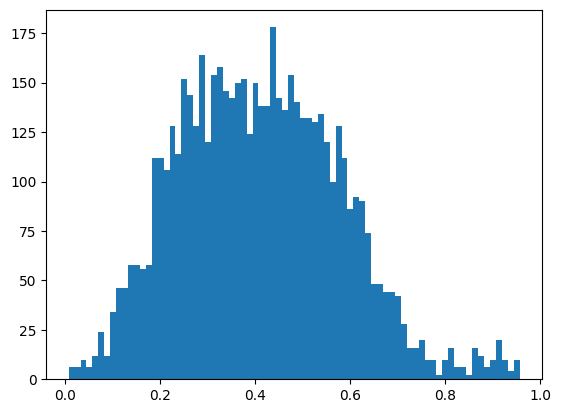

In [39]:
# calculate distance between vectorized texts
"""
Available distance metrics are:
  ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’,
  ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulczynski1’,
  ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’,
  ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.
"""
#matrix = distance_calculator(counts, "cityblock", corpus_metadata.index)
matrix = distance_calculator(counts, "cosine", corpus_metadata.index)

# Show the values of the matrix
#matrix

# Remove the digonal of the matrix as it contains distances being zero.
arr = matrix.values
arr_no_diag = arr[~np.eye(arr.shape[0], dtype=bool)]
# Flatten for ...
arr_no_diag.flatten()
# ... sorting to determine smallest and largest distances later.
arr_no_diag.sort()
#print(arr_no_diag)

# Plot the histogram of the flattend matrix
import matplotlib.pyplot as plt
plt.hist(arr_no_diag,bins=76) # 76 bins or less because there are 76 Documents

# Minimum/smallest distance
min_value = arr_no_diag[0]
min_location = (matrix == min_value)
# Get row and column index for the smallest distance
row_idx, col_name = min_location.stack().idxmax()
print(f"\nSmallest distance between documents: {min_value}\nRow: {row_idx}\nCol: '{col_name}'\n")

# Maximum/largest distance
max_value = arr_no_diag[-1]
max_location = (matrix == max_value)
# Get row and column index for the smallest distance
row_idx, col_name = max_location.stack().idxmax()
print(f"Largest distance between documents: {max_value}\nRow: {row_idx}\nCol: '{col_name}'\n")

In [31]:
# visualize matrix
fig = px.imshow(matrix)

# adjust size of the matrix
fig.update_layout(
    autosize=False,
    width=1500,
    height=1500,
)
fig.show()

In [32]:
# reduce matrix dimensions
reduced_tsne = reduce_dimensions_tsne(matrix, perplexity=matrix.shape[0]**0.5, n_iter=5000, metric="euclidean", metadata=corpus_metadata)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [33]:
# visualize reduced dimensions

# adjust size column for visualization
size_min = 3
size_max = 70
size = (reduced_tsne["partial_length"] / reduced_tsne["partial_length"].max() * (size_max - size_min) + size_min).tolist()

# create figure
# for Akkadian use symbol = "script", color="project",
# for Egyptian
fig = px.scatter(reduced_tsne, x="component 1", y="component 2", size=size, symbol = "corpus_manual", color="language_manual", hover_data=["partial_length", "full_length", reduced_tsne.index])
fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.show()

# Find Shared Tokens

**creates a mini df that includes only the chosen text and the shared tokens in those texts**
  (i.e., all tokens that are none zero in all texts).
* param df: the counts_df where the index is the text ids and the columns are the tokens.
* param text_ids: a list containing text ids.
* return: a dataframe where the index are the shared tokens and the columns are the texts.
           the values are the tf-idf scores.

In [34]:
def find_shared_tokens(df, text_ids):

  mini_df = df[df.index.isin(text_ids)].copy()
  mini_df = mini_df.loc[:, (mini_df != 0).all(axis=0)].copy()
  return mini_df.transpose()

In [35]:
# Akkadian
#shared_tokens = find_shared_tokens(counts_df, ["Q003450", "Q003711", "Q003790"])
# Egyptian
shared_tokens = find_shared_tokens(counts_df, ["pBerlin P 3023 + pAmherst I (Bauer, B1) || Der beredte Bauer (Version B1)", "pBerlin P 3025 + pAmherst II (Bauer, B2) || Der beredte Bauer (Version B2)", "pPetersburg 1116 A || Verso: Die Lehre für Merikare", "pBM EA 10509 (Ptahhotep, Version L2+L2G) || Die Lehre des Ptahhotep (Version L2+L2G)"])#, "3RU7Z4VQ45CYFIQ4PUGQ3HDJFU"])

shared_tokens

text_name,"pBerlin P 3023 + pAmherst I (Bauer, B1) || Der beredte Bauer (Version B1)","pBerlin P 3025 + pAmherst II (Bauer, B2) || Der beredte Bauer (Version B2)","pBM EA 10509 (Ptahhotep, Version L2+L2G) || Die Lehre des Ptahhotep (Version L2+L2G)",pPetersburg 1116 A || Verso: Die Lehre für Merikare
10030,0.157330,0.188642,0.058477,0.166318
10050,0.519172,0.453580,0.574471,0.547236
10090,0.106631,0.068346,0.158898,0.210901
10100,0.025393,0.007884,0.043989,0.133161
10110,0.580085,0.560686,0.598422,0.474904
107529,0.084310,0.037393,0.037092,0.024292
116230,0.038881,0.079010,0.070755,0.051328
129490,0.028568,0.023651,0.073316,0.081945
170100,0.042376,0.032385,0.085330,0.021038
185810,0.105795,0.062233,0.102888,0.053906


In [36]:
px.scatter(shared_tokens)

*This notebook was created by [Avital Romach](https://github.com/ARomach), with additional code and text by [Eliese-Sophia Lincke](https://www.geschkult.fu-berlin.de/e/aegyptologie/personen/Professorinnen-und-Professoren/Lincke/index.html), [Shai Gordin](https://digitalpasts.github.io/) and [Daniel A. Werning](https://www.bbaw.de/die-akademie/mitarbeiterinnen-mitarbeiter/werning-daniel) in Spring 2024 for the course [Ancient Language Processing](https://digitalpasts.github.io/ALP-course/). Code can be reused under a [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)*